<a href="https://colab.research.google.com/github/myomyint-maung/nlp-assignments/blob/main/07-Machine-Translation/07_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 23 Feb - Machine Translation from Myanmar to English

In [1]:
# Import necessary libraries
import torch, torchtext
from torch import nn
import torch.nn.functional as F
import random, math, time

# Choose the computing device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set SEED for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading Data

**Note**: I use the Myanmar and English datasets from the Asian Language Treebank (ALT) Parallel Corpus available at https://www2.nict.go.jp/astrec-att/member/mutiyama/ALT/.

In [2]:
# !git clone https://github.com/myomyint-maung/nlp-assignments.git

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Load the datasets
import pandas as pd

data_my = pd.read_csv('/content/nlp-assignments/07-Machine-Translation/data/data_my.txt', sep='\t', header=None)
data_en = pd.read_csv('/content/nlp-assignments/07-Machine-Translation/data/data_en.txt', sep='\t', header=None)

data_my.columns = ['REF', 'MY']
data_en.columns = ['REF', 'EN']

df = pd.merge(data_my, data_en, on='REF')
df = df.drop('REF', axis=1)
df = df.dropna()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19166 entries, 0 to 19172
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MY      19166 non-null  object
 1   EN      19166 non-null  object
dtypes: object(2)
memory usage: 449.2+ KB


,MY,EN
0,ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂...,Italy have defeated Portugal 31-5 in Pool C of...
1,အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...,Andrea Masi opened the scoring in the fourth m...
2,ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကိ...,Despite controlling the game for much of the f...
3,ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...,Portugal never gave up and David Penalva score...
4,အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...,Italy led 16-5 at half time but were matched b...


In [4]:
# Convert the dataframe into a list of parallel corpus
corpus = df.values.tolist()

corpus[0:5]

[['ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။',
  'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.'],
 ['အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု အဖြစ် စတုတ္ထ မိနစ် တွင် အမှတ်ပေးခြင်း ကို ဖွင့်လှစ်ပေးခဲ့သည် ။',
  'Andrea Masi opened the scoring in the fourth minute with a try for Italy.'],
 ['ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကို ထိန်းချုပ်ခြင်း မရှိခဲ့လျှင် အီတလီ သည် ပွဲနားချိန် မတိုင်မှီ အခြား မည်သည့် ကြိုးစားမှု များ ကိုမှ အမှတ် မရနိုင် ပေမယ့် ဒေးဗစ် ဘော်တိုလပ်စီ သည် သူတို့၏ ဦးဆောင်မှု ကို အဓွန့်ရှည် စေရန် ပယ်နယ်လ်တီ ၃ဂိုး သွင်းပေးခဲ့သည် ။',
  'Despite controlling the game for much of the first half, Italy could not score any other tries before the interval but David Bortolussi kicked three penalties to extend their lead.'],
 ['ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့ ပဲ ဒေးဗစ် ပန်နယ်ဗါ သည်

## 2. Splitting Data

In [5]:
# Check the size of the corpus
corpus_size = len(corpus)

corpus_size

19166

In [6]:
# Split the corpus into training, validataion and test sets
random.shuffle(corpus)

train_size = int(corpus_size * 0.7)
val_size   = int(corpus_size * 0.1)

train = corpus[:train_size]
val   = corpus[train_size:(train_size + val_size)]
test  = corpus[(train_size + val_size):]

len(train), len(val), len(test), len(train)+len(val)+len(test)

(13416, 1916, 3834, 19166)

## 3. Preprocessing 

### Tokenizing

In [7]:
# Assign the source and target languages
SRC_LANGUAGE = 'MY'
TRG_LANGUAGE = 'EN'

In [8]:
# Assign place-holders
token_transform = {}
vocab_transform = {}

In [9]:
# !pip install pyidaungsu

In [10]:
# Creat the Myanmar tokenizer
import pyidaungsu.tokenize as tokenize

def myanmar_tokenizer(text):
    return tokenize(text, form='word')

token_transform[SRC_LANGUAGE] = myanmar_tokenizer

print("Sentence: ", train[0][0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](train[0][0]))

Sentence:  ၂၀၀၅ ခုနှစ် ၊ မတ်လ ၂၂ ရက် ကြာသပတေးနေ့ တွင် ၊ လပ် ဗေးဂက်စ် မှ အမျိုးသမီး တစ်ဦး ဖြစ်သော ၊ အန်န အရလ သည် ၊ ဖရက်နိုဘေ့စ် ဂျန် မန်းနစ်ရှ်မက် မှ ပိုင်ဆိုင်သော ၊ ကယ်လီဖိုးနီးယားပြည်နယ် ၊ စံဂျိုး မြို့လယ် ၏ တောင်ဘက် တည့်တည့် ရှိ ၊ ၁၄၀၅ မွန်တရေး အမြန်လမ်း တွင် တည်ရှိသော ဝမ်းဒီစ် စားသောက်ဆိုင် တစ်ဆိုင် တွင် သူမ ၏ ငရုတ်ဆီ ပန်းကန် ထဲမှ လူ ၏ လက်ချောင်း တစ်ခု တွေ့ရှိခဲ့ ကြောင်း အခိုင်အမာပြောဆိုခဲ့သည် ။
Tokenization:  ['၂၀၀၅', 'ခုနှစ်', '၊', 'မတ်', 'လ', '၂၂', 'ရက်', 'ကြာသပတေး', 'နေ့', 'တွင်', '၊', 'လပ်', 'ဗေးဂက်စ်', 'မှ', 'အမျိုးသမီး', 'တစ်', 'ဦး', 'ဖြစ်', 'သော', '၊', 'အန်န', 'အရ', 'လ', 'သည်', '၊', 'ဖရက်နိုဘေ့စ်ဂျန်မန်းနစ်ရှ်မက်', 'မှ', 'ပိုင်ဆိုင်', 'သော', '၊', 'ကယ်လီဖိုးနီးယား', 'ပြည်နယ်', '၊', 'စံဂျိုး', 'မြို့', 'လယ်', '၏', 'တောင်', 'ဘက်', 'တည့်', 'တည့်', 'ရှိ', '၊', '၁၄၀၅', 'မွန်တရေး', 'အမြန်လမ်း', 'တွင်', 'တည်ရှိ', 'သော', 'ဝမ်းဒီစ်စားသောက်ဆိုင်', 'တစ်', 'ဆိုင်', 'တွင်', 'သူမ', '၏', 'ငရုတ်ဆီပန်းကန်', 'ထဲ', 'မှ', 'လူ', '၏', 'လက်ချောင်း', 'တစ်', 'ခု', 'တွေ့', 'ရှိ', 'ခဲ့', 'ကြောင်း', 'အခ

In [11]:
# Creat the English tokenizer
from torchtext.data.utils import get_tokenizer
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

print("Sentence: ", train[0][1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](train[0][1]))

Sentence:  On Thursday the 22nd of March, 2005, Anna Ayala, a woman from Las Vegas, claimed to have found a human finger in her bowl of chili at a Wendy's restaurant located at 1405 Monterey Highway, just south of downtown San Jose, California, owned by Fresno-based Jern Management..
Tokenization:  ['On', 'Thursday', 'the', '22nd', 'of', 'March', ',', '2005', ',', 'Anna', 'Ayala', ',', 'a', 'woman', 'from', 'Las', 'Vegas', ',', 'claimed', 'to', 'have', 'found', 'a', 'human', 'finger', 'in', 'her', 'bowl', 'of', 'chili', 'at', 'a', 'Wendy', "'s", 'restaurant', 'located', 'at', '1405', 'Monterey', 'Highway', ',', 'just', 'south', 'of', 'downtown', 'San', 'Jose', ',', 'California', ',', 'owned', 'by', 'Fresno', '-', 'based', 'Jern', 'Management', '..']


In [13]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

In [14]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Numericalization

In [15]:
# Build vocab
# from torchtext.vocab import build_vocab_from_iterator

# for ln in [SRC_LANGUAGE, TRG_LANGUAGE]: 
#     vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
#                                                     min_freq=2,
#                                                     specials=special_symbols,
#                                                     special_first=True)

# for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
#     vocab_transform[ln].set_default_index(UNK_IDX)

In [16]:
# Save vocab
# import pickle

# file_path = '/content/nlp-assignments/07-Machine-Translation/vocab_transform.pkl'

# with open(file_path, 'wb') as file:
#     pickle.dump(vocab_transform, file)


In [17]:
# Load the saved vocab
import pickle

file_path = '/content/nlp-assignments/07-Machine-Translation/vocab_transform.pkl'

with open(file_path, 'rb') as file:
    vocab_transform = pickle.load(file)

In [18]:
#see some examples
print(vocab_transform[SRC_LANGUAGE](['ပြင်သစ်', 'အီတလီ', 'ကုလသမဂ္ဂ', 'ဘလာဘလာ', 'ကုလသမဂ္ဂ']))
print(vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a']))

[414, 909, 479, 0, 479]
[978, 18, 11, 0, 11]


In [19]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

mapping[479]

'ကုလသမဂ္ဂ'

In [20]:
#let's try unknown vocab
mapping[0]

'<unk>'

In [21]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [22]:
#check unique vocabularies
len(mapping)

11102

## 4. Preparing Dataloaders

In [23]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [24]:
# Create traning, validataion and test dataloaders
batch_size = 8

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [25]:
# Test the train_loader
for my, _, en in train_loader:
    break

print("Myanmar shape: ", my.shape)  # (seq len, batch_size)
print("English shape: ", en.shape)   # (seq len, batch_size)

Myanmar shape:  torch.Size([55, 8])
English shape:  torch.Size([45, 8])


## 5. Modeling

### Encoder

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):

        embedded = self.dropout(self.embedding(src))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)        

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        return outputs, hidden

### Additive Attention

In [27]:
class AdditiveAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        batch_size = encoder_outputs.shape[1]

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
        
        attention = self.v(energy).squeeze(2)

        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

### Multiplicative Attention

In [28]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        batch_size = encoder_outputs.shape[1]
        
        wh = self.W(hidden).unsqueeze(1).repeat(1, 1, 2)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.bmm(wh, encoder_outputs.transpose(1, 2))
        
        attention = energy.squeeze(1)

        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

### General Attention

In [29]:
class GeneralAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        batch_size = encoder_outputs.shape[1]

        hidden = hidden.unsqueeze(1).repeat(1, 1, 2)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
        
        attention = energy.squeeze(1)

        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

In [30]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
      
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden, encoder_outputs, mask)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted = torch.bmm(a, encoder_outputs)

        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)
   
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src == self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)

        encoder_outputs, hidden = self.encoder(src, src_len)

        input_ = trg[0,:]
        
        mask = self.create_mask(src)
                
        for t in range(1, trg_len):

            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)

            outputs[t] = output

            attentions[t] = attention

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1) 

            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

## 6. Training

### Additive Attention

In [32]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [33]:
# Set hyperparameters
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 64  
hid_dim     = 128  
dropout     = 0.5
lr          = 0.001

In [34]:
# Initialize the model
attn = AdditiveAttention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

SRC_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(11102, 64)
    (rnn): GRU(64, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): AdditiveAttention(
      (v): Linear(in_features=128, out_features=1, bias=False)
      (W): Linear(in_features=128, out_features=128, bias=True)
      (U): Linear(in_features=256, out_features=128, bias=True)
    )
    (embedding): Embedding(14382, 64)
    (gru): GRU(320, 128)
    (fc): Linear(in_features=448, out_features=14382, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
# Print the number of model parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

710528
 24576
 49152
   384
   384
 24576
 49152
   384
   384
 32768
   128
   128
 16384
   128
 32768
   128
920448
122880
 49152
   384
   384
6443136
 14382
______
8492718


In [36]:
# Loss and optimizer
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [37]:
# Create the function for training
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [38]:
# Create the function for evaluation
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [39]:
# Find the lengths of the dataloaders
# train_loader_length = len(list(iter(train_loader)))
# val_loader_length   = len(list(iter(val_loader)))
# test_loader_length  = len(list(iter(test_loader)))

train_loader_length = 1677
val_loader_length   = 240
test_loader_length  = 480

In [42]:
# Create the function to calculate training epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [43]:
# Create the folder to save models
import os
from os import path

if path.exists('./models') == False:
  os.mkdir('./models')

In [44]:
# Train the model
best_val_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'./models/Additive{model.__class__.__name__}.pt'

train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    val_loss   = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. PPL: {math.exp(val_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 4m 32s
	Train Loss: 6.558 | Train PPL: 704.741
	 Val. Loss: 6.516 |  Val. PPL: 675.623
Epoch: 02 | Time: 4m 31s
	Train Loss: 6.064 | Train PPL: 430.149
	 Val. Loss: 6.400 |  Val. PPL: 601.620
Epoch: 03 | Time: 4m 35s
	Train Loss: 5.767 | Train PPL: 319.717
	 Val. Loss: 6.275 |  Val. PPL: 531.047
Epoch: 04 | Time: 4m 32s
	Train Loss: 5.510 | Train PPL: 247.266
	 Val. Loss: 6.181 |  Val. PPL: 483.625
Epoch: 05 | Time: 4m 30s
	Train Loss: 5.268 | Train PPL: 194.119
	 Val. Loss: 6.143 |  Val. PPL: 465.300


Text(0, 0.5, 'loss')

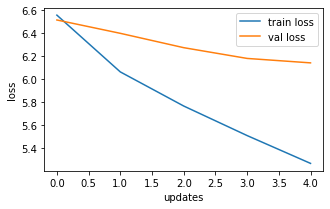

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'val loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [46]:
# Evaluate the model with the test set
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.142 | Test PPL: 464.772 |


## 7. Testing on Random Samples

In [47]:
sample = corpus[0]

In [48]:
sample[0], sample[1]

('၂၀၀၅ ခုနှစ် ၊ မတ်လ ၂၂ ရက် ကြာသပတေးနေ့ တွင် ၊ လပ် ဗေးဂက်စ် မှ အမျိုးသမီး တစ်ဦး ဖြစ်သော ၊ အန်န အရလ သည် ၊ ဖရက်နိုဘေ့စ် ဂျန် မန်းနစ်ရှ်မက် မှ ပိုင်ဆိုင်သော ၊ ကယ်လီဖိုးနီးယားပြည်နယ် ၊ စံဂျိုး မြို့လယ် ၏ တောင်ဘက် တည့်တည့် ရှိ ၊ ၁၄၀၅ မွန်တရေး အမြန်လမ်း တွင် တည်ရှိသော ဝမ်းဒီစ် စားသောက်ဆိုင် တစ်ဆိုင် တွင် သူမ ၏ ငရုတ်ဆီ ပန်းကန် ထဲမှ လူ ၏ လက်ချောင်း တစ်ခု တွေ့ရှိခဲ့ ကြောင်း အခိုင်အမာပြောဆိုခဲ့သည် ။',
 "On Thursday the 22nd of March, 2005, Anna Ayala, a woman from Las Vegas, claimed to have found a human finger in her bowl of chili at a Wendy's restaurant located at 1405 Monterey Highway, just south of downtown San Jose, California, owned by Fresno-based Jern Management..")

In [49]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,  749,   60,    7,  428,   62,  998,  121,  531,   56,   14,    7,
        9639,    0,   25,  283,   15,   81,   19,   10,    7,    0,   89,   62,
           4,    7,    0,   25,  485,   10,    7,  800,  134,    7,    0,  110,
        3054,   11,  157,  108, 4977, 4977,   18,    7,    0,    0, 6978,   14,
         458,   10,    0,   15,  192,   14,  141,   11,    0,   85,   25,   91,
          11,    0,   15,   20,  113,   18,    5,   75,  384,  130,    5,    4,
           8,    3], device='cuda:0')

In [50]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([    2,   223,   244,     4,  6822,     7,   305,     5,   299,     5,
         3273,     0,     5,    11,   674,    25, 11423,     0,     5,   376,
            8,    24,   117,    11,   570, 13079,    10,    83,  9213,     7,
            0,    26,    11,     0,    20,  5728,   629,    26,     0,     0,
         4675,     5,   139,  1203,     7,  3147,   663,  3306,     5,   525,
            5,  1036,    21,     0,    17,   291,     0,  3310,  8105,     3],
       device='cuda:0')

In [51]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [52]:
trg_text = trg_text.reshape(-1, 1)

In [53]:
src_text.shape, trg_text.shape

(torch.Size([74, 1]), torch.Size([60, 1]))

In [54]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [55]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [56]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([60, 1, 14382])

Since batch size is 1, we just take off that dimension

In [57]:
output = output.squeeze(1)

In [58]:
output.shape

torch.Size([60, 14382])

We shall remove the first token since it's zeroes anyway

In [59]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([59, 14382])

Then we just take the top token with highest probabilities

In [60]:
output_max = output.argmax(1) #returns max indices

In [61]:
output_max

tensor([14,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  5,  0,  5,  0,  5,
         0,  5,  0,  5,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  3,
         3,  0,  6,  3,  3], device='cuda:0')

Get the mapping of the target language

In [62]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [63]:
for token in output_max:
    print(mapping[token.item()])

The
,
,
,
,
,
,
,
,
,
,
,
<unk>
,
<unk>
,
<unk>
,
<unk>
,
<unk>
,
<unk>
<unk>
,
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
.
<eos>
<eos>
<unk>
.
<eos>
<eos>


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [ ]:
attentions.shape

torch.Size([19, 1, 24])

In [ ]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'အမေရိကန်',
 'နှင့်',
 'ဩစတေးလျ',
 'တွင်',
 'တက်ကြွ',
 'သော',
 'ရုံး',
 'ခွဲ',
 'များ',
 'နှင့်',
 'နယူးဇီလန်',
 'တွင်',
 'အဖွဲ့',
 'ဝင်',
 'များ',
 'မှာ',
 '၂၀၀၀',
 'နီးပါး',
 'ရှိ',
 'ပါ',
 'သည်',
 '။',
 '<eos>']

In [ ]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

In [ ]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/tmp/ipykernel_2592381/59549304.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_2592381/59549304.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


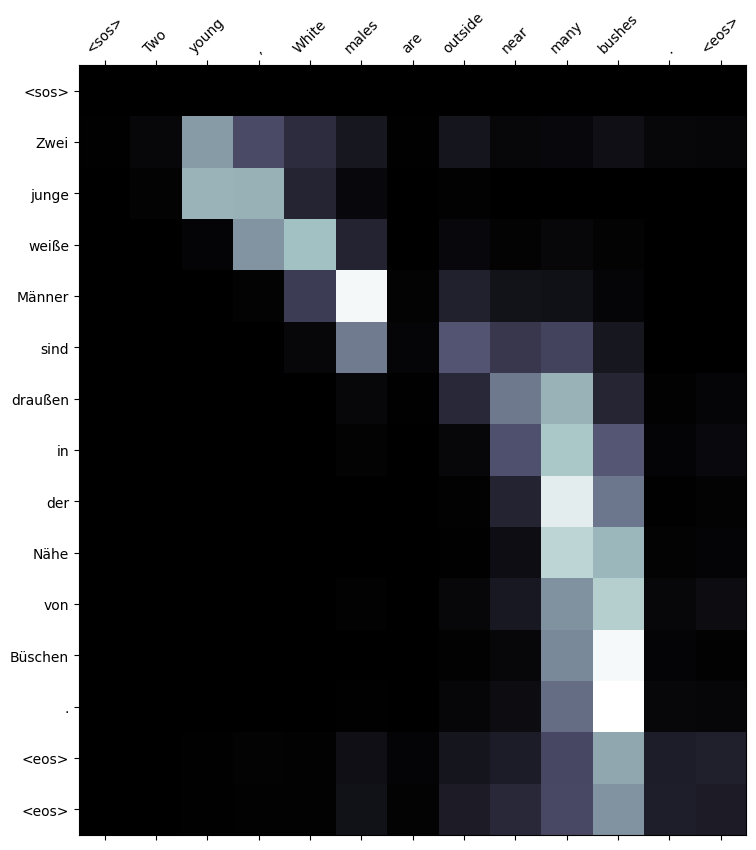

In [ ]:
display_attention(src_tokens, trg_tokens, attentions)

## Conclusion

Nice!  We get the similar perplexity but with much faster computations, thanks to packed sequences and masking.   We also can see attention by our eyes, so we should believe it now!